In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob
from scipy.stats import normaltest, gaussian_kde, probplot
from scipy.optimize import curve_fit
import time
from tqdm import tqdm

In [5]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
noise_values = np.logspace(start = -8, stop = 2, num = 100)
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]
num_exp = 100  # Number of experiments to run for each image pair and noise level

In [3]:
results_B_x = pd.DataFrame(columns=[
    'Category', 'Image_Pair', 'Alpha_1_Mean', 'Alpha_1_Std', 'Alpha_2_Mean', 'Alpha_2_Std', 'B_x_Mean', 'B_x_Std', 'Noise', 'B_x_tilde_Mean', 'B_x_tilde_Std'])

for category in category_names:
    print(f'Category: {category}')
    for noise in noise_values:
        for pair in list(itertools.combinations(image_numbers, 2)):
            alpha_1s = np.zeros(num_exp)
            alpha_2s = np.zeros(num_exp)
            B_xs = np.zeros((num_exp, resolution, resolution))  # Store B_x for each experiment
            B_xs_tilde = np.zeros((num_exp, resolution, resolution))  # Store B_x_tilde for each experiment
            image1 = Image(resolution, category_names[0], pair[0], full_path)
            image2 = Image(resolution, category_names[0], pair[1], full_path)

            for i in range(num_exp):
                results = Image.process_images(image1, image2, noise)
                alpha_1 = (1 / image1.image_post_noised.sum()) - 1
                alpha_2 = (1 / image2.image_post_noised.sum()) - 1
                B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2
                alpha_1s[i] = alpha_1
                alpha_2s[i] = alpha_2
                B_xs[i, :, :] = B_x  # Store each B_x result
                B_xs_tilde[i, :, :] = B_x - alpha_1 * image1.image + alpha_2 * image2.image

            # Calculate the means and standard deviations
            alpha_1_mean, alpha_1_std = alpha_1s.mean(), alpha_1s.std()
            alpha_2_mean, alpha_2_std = alpha_2s.mean(), alpha_2s.std()
            B_x_mean, B_x_std = B_xs.mean(axis=0), B_xs.std(axis=0)
            B_x_tilde_mean, B_x_tilde_std = B_xs_tilde.mean(axis=0), B_xs_tilde.std(axis=0)

            # Store results in the DataFrame
            results_B_x = results_B_x._append({
                'Category': category,
                'Noise': noise,
                'Image_Pair': pair,
                'Alpha_1_Mean': alpha_1_mean,
                'Alpha_1_Std': alpha_1_std,
                'Alpha_2_Mean': alpha_2_mean,
                'Alpha_2_Std': alpha_2_std,
                'B_x_Mean': B_x_mean.mean(),  # Storing the overall mean of the matrix
                'B_x_Std': B_x_std.mean(),  # Storing the overall mean of the std of the matrix
                'B_x_tilde_Mean': B_x_tilde_mean.mean(),
                'B_x_tilde_Std': B_x_tilde_std.mean()
            }, ignore_index=True)

Category: CauchyDensity


C:\Users\eriki\AppData\Local\Temp\ipykernel_13732\2449704004.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_B_x = results_B_x._append({


Category: ClassicImages
Category: GRFmoderate
Category: GRFrough
Category: GRFsmooth
Category: LogGRF
Category: LogitGRF
Category: MicroscopyImages
Category: Shapes
Category: WhiteNoise


In [16]:
results_B_x.head()

,Alpha_1_Mean,Alpha_1_Std,Alpha_2_Mean,Alpha_2_Std,B_x_Mean,B_x_Std,Noise,B_x_tilde_Mean,B_x_tilde_Std,log_Noise
0,-0.000002,3.038422e-07,-0.000002,3.264370e-07,4.393059e-11,5.157496e-10,1.000000e-08,1.948400e-16,2.942901e-14,-8.0
1,-0.000002,2.680694e-07,-0.000002,3.055816e-07,1.776389e-11,4.781678e-10,1.000000e-08,8.006727e-17,2.362551e-14,-8.0
2,-0.000002,3.034657e-07,-0.000002,3.100990e-07,-6.924693e-11,4.597700e-10,1.000000e-08,-2.250760e-16,2.368561e-14,-8.0
3,-0.000002,2.732682e-07,-0.000002,3.550272e-07,-2.194785e-11,5.894048e-10,1.000000e-08,-2.272101e-17,2.375797e-14,-8.0
4,-0.000002,2.242894e-07,-0.000002,3.245676e-07,2.432814e-11,4.868909e-10,1.000000e-08,1.337113e-16,2.354415e-14,-8.0


In [19]:
#results_B_x_new = results_B_x.drop(['Category', 'Image_Pair'], axis=1)
#results_B_x_new['log_Noise'] = np.log10(results_B_x['Noise'])
grouped_results = results_B_x.groupby('Noise').mean().reset_index()

In [20]:
# Logistic function for Alpha Mean
def logistic(x, A, B, C):
    return A / (1 + np.exp(B * (x - C)))

# Gaussian function for Alpha Std
def gaussian(x, D, E, F):
    return D * np.exp(-((x - E) ** 2) / (2 * F ** 2))

In [21]:
params_erik = [-1, -np.pi, -np.e]

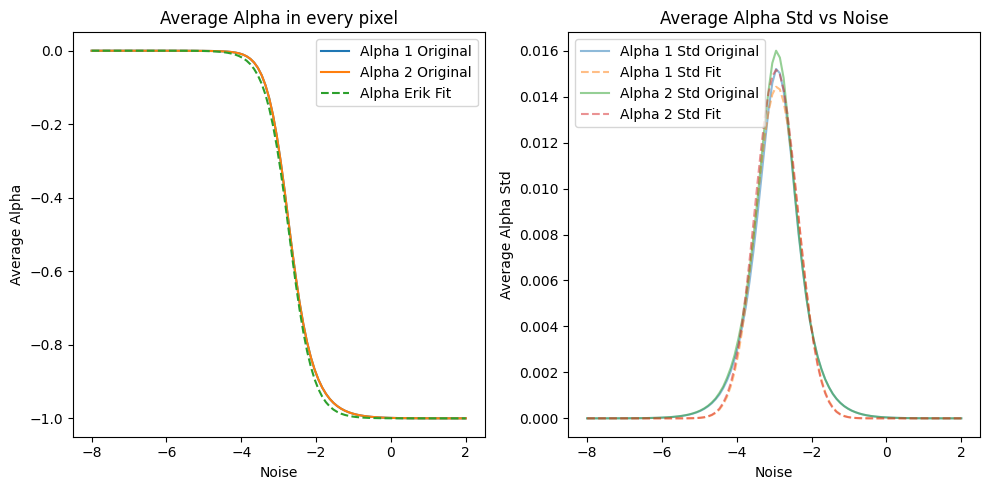

In [22]:
# Fit the models for Alpha 1 Mean
params_mean_1, _ = curve_fit(logistic, grouped_results['log_Noise'], grouped_results['Alpha_1_Mean'], p0=[1, 1, 0])
params_mean_2, _ = curve_fit(logistic, grouped_results['log_Noise'], grouped_results['Alpha_2_Mean'], p0=[1, 1, 0])

# Fit the models for Alpha 1 Std
params_std_1, _ = curve_fit(gaussian, grouped_results['log_Noise'], grouped_results['Alpha_1_Std'], p0=[0.01, 0, 1])
params_std_2, _ = curve_fit(gaussian, grouped_results['log_Noise'], grouped_results['Alpha_2_Std'], p0=[0.01, 0, 1])

# Generate fitted values
fitted_mean_1 = logistic(grouped_results['log_Noise'], *params_mean_1)
fitted_mean_2 = logistic(grouped_results['log_Noise'], *params_mean_2)
fitted_mean_erik = logistic(grouped_results['log_Noise'], *params_erik)
fitted_std_1 = gaussian(grouped_results['log_Noise'], *params_std_1)
fitted_std_2 = gaussian(grouped_results['log_Noise'], *params_std_2)

# Plot the alphas:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_1_Mean'], label='Alpha 1 Original')
# plt.plot(grouped_results['log_Noise'], fitted_mean_1, label='Alpha 1 Fit', linestyle='--')
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_2_Mean'], label='Alpha 2 Original')
# plt.plot(grouped_results['log_Noise'], fitted_mean_2, label='Alpha 2 Fit', linestyle='--')
plt.plot(grouped_results['log_Noise'], fitted_mean_erik, label='Alpha Erik Fit', linestyle='--')
plt.xlabel('Noise')
plt.ylabel('Average Alpha')
plt.title('Average Alpha in every pixel')
plt.legend()

# Plot Alpha Std vs Noise
plt.subplot(1, 2, 2)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_1_Std'], label='Alpha 1 Std Original', alpha=0.5)
plt.plot(grouped_results['log_Noise'], fitted_std_1, label='Alpha 1 Std Fit', linestyle='--', alpha=0.5)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_2_Std'], label='Alpha 2 Std Original', alpha=0.5)
plt.plot(grouped_results['log_Noise'], fitted_std_2, label='Alpha 2 Std Fit', linestyle='--', alpha=0.5)
plt.xlabel('Noise')
plt.ylabel('Average Alpha Std')
plt.title('Average Alpha Std vs Noise')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Print the parameters of the mean
print('Alpha 1 Mean:')
print('A:', params_mean_1[0])
print('B:', params_mean_1[1])
print('C:', params_mean_1[2])
print('Alpha 2 Mean:')
print('A:', params_mean_2[0])
print('B:', params_mean_2[1])
print('C:', params_mean_2[2])

Alpha 1 Mean:
A: -0.9956292791046034
B: -3.165276311834175
C: -2.6796735479597857
Alpha 2 Mean:
A: -0.9956292344121789
B: -3.165257888673122
C: -2.679674471169768


# Check the Normality of alpha for specific noise values.

In [45]:
#Check the normality of alpha 1 and alpha 2
alpha_df = pd.DataFrame()
num_exp = 500

for noise in tqdm(noise_values):
    for pair in list(itertools.combinations(image_numbers, 2)):
        alpha_1s = np.zeros(num_exp)
        alpha_2s = np.zeros(num_exp)
        image1 = Image(resolution, category_names[0], pair[0], full_path)
        image2 = Image(resolution, category_names[0], pair[1], full_path)

        for i in range(num_exp):
            results = Image.process_images(image1, image2, noise)
            alpha_1 = (1 / image1.image_post_noised.sum()) - 1
            alpha_2 = (1 / image2.image_post_noised.sum()) - 1
            alpha_1s[i] = alpha_1
            alpha_2s[i] = alpha_2

        # Calculate the means and standard deviations
        alpha_1_mean, alpha_1_std = alpha_1s.mean(), alpha_1s.std()
        alpha_2_mean, alpha_2_std = alpha_2s.mean(), alpha_2s.std()

        # Store results in the DataFrame
        alpha_df = alpha_df._append({
            'Noise': noise,
            'alpha_1': alpha_1_mean,
            'alpha_2': alpha_2_mean,
            'alpha_1_std': alpha_1_std,
            'alpha_2_std': alpha_2_std,
            'alpha_1_p_value': normaltest(alpha_1s)[1],
            'alpha_2_p_value': normaltest(alpha_2s)[1]          
        }, ignore_index=True)

100%|██████████| 100/100 [03:38<00:00,  2.19s/it]


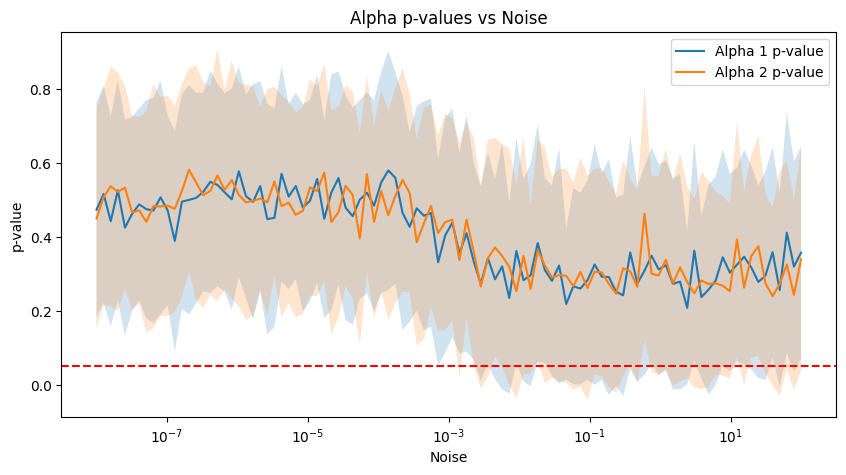

In [46]:
grouped_mean = alpha_df.groupby('Noise').mean().reset_index()
grouped_std = alpha_df.groupby('Noise').std().reset_index()

# Plot the mean p-values vs noise
plt.figure(figsize=(10, 5))
plt.plot(grouped_mean['Noise'], grouped_mean['alpha_1_p_value'], label='Alpha 1 p-value')
plt.plot(grouped_mean['Noise'], grouped_mean['alpha_2_p_value'], label='Alpha 2 p-value')

# Add shaded area for standard deviation
plt.fill_between(grouped_mean['Noise'], grouped_mean['alpha_1_p_value'] - grouped_std['alpha_1_p_value'], 
                 grouped_mean['alpha_1_p_value'] + grouped_std['alpha_1_p_value'], alpha=0.2)
plt.fill_between(grouped_mean['Noise'], grouped_mean['alpha_2_p_value'] - grouped_std['alpha_2_p_value'], 
                 grouped_mean['alpha_2_p_value'] + grouped_std['alpha_2_p_value'], alpha=0.2)

plt.axhline(y=0.05, color='r', linestyle='--')
plt.xlabel('Noise')
plt.xscale('log')
plt.ylabel('p-value')
plt.title('Alpha p-values vs Noise')
plt.legend()
plt.show()

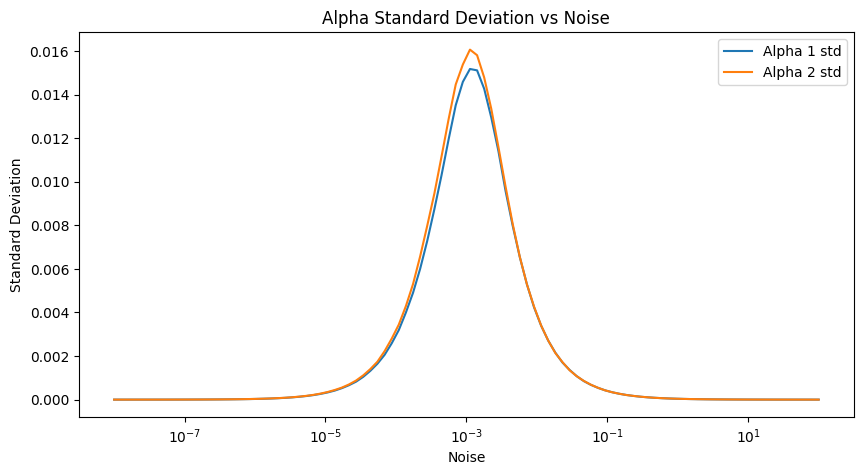

In [47]:
grouped = alpha_df.groupby('Noise').mean().reset_index()

# Plot the p-values vs noise
plt.figure(figsize=(10, 5))
plt.plot(grouped['Noise'], grouped['alpha_1_std'], label='Alpha 1 std')
plt.plot(grouped['Noise'], grouped['alpha_2_std'], label='Alpha 2 std')
plt.xlabel('Noise')
plt.xscale('log')
plt.ylabel('Standard Deviation')
plt.title('Alpha Standard Deviation vs Noise')
plt.legend()
plt.show()

## Experiment on a single pair

In [48]:
pair = list(itertools.combinations(image_numbers, 2))[0]
noise = noise_values[10]

alpha_1s = np.zeros(num_exp)
alpha_2s = np.zeros(num_exp)
image1 = Image(resolution, category_names[0], pair[0], full_path)
image2 = Image(resolution, category_names[0], pair[1], full_path)

for i in range(num_exp):
    results = Image.process_images(image1, image2, noise)
    alpha_1 = (1 / image1.image_post_noised.sum()) - 1
    alpha_2 = (1 / image2.image_post_noised.sum()) - 1
    alpha_1s[i] = alpha_1
    alpha_2s[i] = alpha_2

Alpha 1: 0.6795510330130581
Alpha 2: 0.37688322375180716


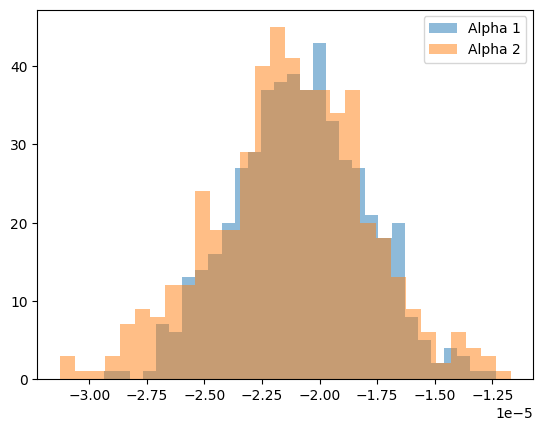

In [49]:
plt.hist(alpha_1s, bins=30, alpha=0.5, label='Alpha 1')
plt.hist(alpha_2s, bins=30, alpha=0.5, label='Alpha 2')
# Check if the data is normally distributed
print('Alpha 1:', normaltest(alpha_1s)[1])
print('Alpha 2:', normaltest(alpha_2s)[1])
plt.legend()
plt.show()